# Movie Recommendation Pipeline with Diversification

This notebook serves as a simple demo for the pass Culture recommender pipeline. The original pipeline is described in the figure 1: 
![alt text](images/pipeline_diagram.png "Figure 1: pass Culture recommender system pipeline")

This notebook only replicates the Two tower retreival model, the semantic embeddings with all-mini-L6-v2 and the DPP filter. The main goal of this notebook is to:
- Serve as a simple demo for our paper
- Give practioners a ready-to-use notebook to test DPP architecture in recommenders systems
- Show the effect of DPP filtering on diversity of recommendations

## Dataset:
The original data at pass culture contains items and the description of the items (for example: a movie and the plot of the movie, or a book and the description of the book). These descriptions are used to generate semantic embedding for the items. To mimic the pass culture, we use the movieLens dataset in this notebook. To get "item descriptions", we use [`vishnupriyavr/wiki-movie-plots-with-summaries`]( https://huggingface.co/datasets/vishnupriyavr/wiki-movie-plots-with-summaries) dataset to get movies plots which will be later embedded by [`all-mini-l6-v2`](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2). 923 movies are kept after filtering.

## Steps covered in this notebook
### "Offline" steps:
- Load and preprocess movieLens movies and ratings data only keeping those that have a plot summary in the wiki-movie-plots-with-summaries dataset.
- Compute semantic embeddings of movies plots with `all-mini-l6-v2`.
- Train a two-tower retrieval model following the tensorflow recommenders [tutoriel](https://www.tensorflow.org/recommenders/examples/basic_retrieval)
- Build a vector database to store movies two-tower embeddings, used later for retrieval.

### Online steps:
- Create the DPP module through `DiversificationPipeline` class
- Benchmark retrieval vs retrieval + DPP:
    - For one user, retrieve 100 movies with the Two Tower retrieval model 
    - Get the top 10 recommendations with highest cosine similarity with the user (TT-reco)
    - Sample 10 diversified movies from the 100 retrieved recommendations. (TT+DPP-reco)
    - Plot the two sets of recommendations in a 2D plot by projecting the item embeddings with a PCA.
    - Compute volume metric : The volume of the recommended items is a measure of diversification. It is computed as the square root of the determinant of the matrix containing semantic embeddings of the items. The bigger the volume, the more diversified the set of items is.


In [1]:
## imports
from typing import Dict, Text, List

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

from sentence_transformers import SentenceTransformer

from dppy.finite_dpps import FiniteDPP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import os
import random

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Offline steps:
1. Step 1: load and preprocess movieLens data 
2. Step 2: compute semantic embeddings of movies plot summaries
3. Step 3: Build and train the two tower model
4. Step 4: Build a vector database containing the movies two-tower embeddings 

## Step 1: load and preprocess movieLens data 
- only keep movies which have a plot summary
- create a train dataset with 50k samples and a test set with about 16k samples.

In [2]:
%%time
# Load the movie plots dataset from HuggingFace 
df_movies_plots = pd.read_csv(
    "hf://datasets/vishnupriyavr/wiki-movie-plots-with-summaries/wiki_movie_plots_deduped_with_summaries.csv"
)[['Title', 'PlotSummary']]

df_movies_plots.drop_duplicates(subset=['Title'], keep='last', inplace=True)

download_config = tfds.download.DownloadConfig(verify_ssl = False)

## Load movies and ratings dataset from TFRS
ratings = tfds.load("movielens/100k-ratings", split="train", download_and_prepare_kwargs={'download_config': download_config})
movies = tfds.load("movielens/100k-movies", split="train", download_and_prepare_kwargs={'download_config': download_config})


## Filter movies and ratings dataset to keep those with plots
ratings_list = list(ratings)  # Will work for 100k dataset
ratings_dicts = [
    {
        "user_id": x["user_id"].numpy().decode("utf-8"),
        "movie_title": x["movie_title"].numpy().decode("utf-8"),
    }
    for x in ratings_list
]
ratings_df = pd.DataFrame(ratings_dicts)
ratings_df.movie_title = ratings_df.movie_title.map(lambda x: x.split('(')[0].strip())
ratings_df = pd.merge(ratings_df, df_movies_plots, left_on='movie_title', right_on='Title', how='inner')[['user_id', 'movie_title']]
ratings_ds = tf.data.Dataset.from_tensor_slices(dict(ratings_df))

## Filter movies dataset
movies_list = list(movies)  
movies_dicts = [
    {
        "movie_title": x["movie_title"].numpy().decode("utf-8"),
    }
    for x in movies_list
]
movies_df = pd.DataFrame(movies_dicts)
movies_df.movie_title = movies_df.movie_title.map(lambda x: x.split('(')[0].strip())
movies_df = pd.merge(movies_df, df_movies_plots, left_on='movie_title', right_on='Title', how='inner')[['movie_title']]
movies_ds = tf.data.Dataset.from_tensor_slices(dict(movies_df))


# Prepare the ratings dataset for training
ratings_ds = ratings_ds.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
})
movies_ds = movies_ds.map(lambda x: x["movie_title"])


# Shuffle and split the data
tf.random.set_seed(42)
shuffled = ratings_ds.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(50_000) ## After filtering rating_ds has 67,921 rows
test = shuffled.skip(50_000).take(20_000)

# Prepare unique user and movie vocabularies
movie_titles = movies_ds.batch(1_000)
user_ids = ratings_ds.batch(1_000_000).map(lambda x: x["user_id"])
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

# Filter the df_movies_plots dataframe to keep only movies that exist in movielens
df_movies_plots = df_movies_plots[df_movies_plots.Title.isin([str(movie_name.decode("utf-8")) for movie_name in unique_movie_titles])]


Cause: could not parse the source code of <function <lambda> at 0x177e0a7a0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x177e0a7a0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x177e0a7a0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x177e0a560>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x177e0a560>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x177e0a560>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x177e0b010>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x177e0b010>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x177e0b010>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 15.9 s, sys: 2.14 s, total: 18 s
Wall time: 20.4 s


users_list = user_model.layers[0].get_vocabulary()
users_weights = user_model.layers[1].get_weights()[0].astype(np.float32)
user_embedding_dict = {x: y for x, y in zip(users_list, users_weights)}
user_id = users_list[100] # the 101th user_id 

results_top_k, scores_top_k, results_k_diversified, scores_div =  retrieval(10, user_id, user_embedding_dict, use_qi=True)
results_top_k, results_k_diversified

## Step 2: compute semantic embeddings of movies plot summaries


In [3]:
%%time
## Add the semantic embeddings to the df_movies_plots 

# Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings
df_movies_plots['plot_semantic_embedding'] = df_movies_plots['PlotSummary'].apply(lambda x: model.encode(x, convert_to_numpy=True))


CPU times: user 10.8 s, sys: 1.7 s, total: 12.5 s
Wall time: 16.2 s


## Step 3: Build and train the two tower model

In [4]:
%%time
## Define the Two Tower model 
embedding_dimension = 32

user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add an additional embedding to account for unknown tokens.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

movie_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_movie_titles, mask_token=None),
  tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

metrics = tfrs.metrics.FactorizedTopK(
  candidates=movies_ds.batch(128).map(movie_model)
)

task = tfrs.tasks.Retrieval(
  metrics=metrics
)

class MovielensModel(tfrs.Model):
  def __init__(self, user_model, movie_model):
    super().__init__()
    self.movie_model: tf.keras.Model = movie_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_movie_embeddings = self.movie_model(features["movie_title"])

    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_movie_embeddings)

CPU times: user 42.5 ms, sys: 31.2 ms, total: 73.8 ms
Wall time: 93.1 ms


In [5]:
len(train)

50000

In [6]:
len(test)

17921

In [7]:
%%time
## Train the model
model = MovielensModel(user_model, movie_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

cached_train = train.shuffle(100_000, seed=42).batch(8192).cache()
cached_test = test.batch(4096).cache()

model.fit(cached_train, epochs=10)

model.evaluate(cached_test, return_dict=True)

Epoch 1/10
7/7 [==============================] - 3s 256ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0015 - factorized_top_k/top_5_categorical_accuracy: 0.0102 - factorized_top_k/top_10_categorical_accuracy: 0.0229 - factorized_top_k/top_50_categorical_accuracy: 0.1118 - factorized_top_k/top_100_categorical_accuracy: 0.1953 - loss: 56680.9497 - regularization_loss: 0.0000e+00 - total_loss: 56680.9497
Epoch 2/10
7/7 [==============================] - 2s 237ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0045 - factorized_top_k/top_5_categorical_accuracy: 0.0292 - factorized_top_k/top_10_categorical_accuracy: 0.0587 - factorized_top_k/top_50_categorical_accuracy: 0.2387 - factorized_top_k/top_100_categorical_accuracy: 0.3893 - loss: 55125.7568 - regularization_loss: 0.0000e+00 - total_loss: 55125.7568
Epoch 3/10
7/7 [==============================] - 2s 241ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0061 - factorized_top_k/top_5_categorical_accuracy: 0.0

{'factorized_top_k/top_1_categorical_accuracy': 0.00011160091526107863,
 'factorized_top_k/top_5_categorical_accuracy': 0.004017632920295,
 'factorized_top_k/top_10_categorical_accuracy': 0.013280509039759636,
 'factorized_top_k/top_50_categorical_accuracy': 0.12225880473852158,
 'factorized_top_k/top_100_categorical_accuracy': 0.2637687623500824,
 'loss': 11093.8701171875,
 'regularization_loss': 0,
 'total_loss': 11093.8701171875}

In [8]:
model.evaluate(cached_test)

5/5 [==============================] - 0s 88ms/step - factorized_top_k/top_1_categorical_accuracy: 1.1160e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0040 - factorized_top_k/top_10_categorical_accuracy: 0.0133 - factorized_top_k/top_50_categorical_accuracy: 0.1223 - factorized_top_k/top_100_categorical_accuracy: 0.2638 - loss: 26102.2093 - regularization_loss: 0.0000e+00 - total_loss: 26102.2093


[0.00011160091526107863,
 0.004017632920295,
 0.013280509039759636,
 0.12225880473852158,
 0.2637687623500824,
 11093.8701171875,
 0,
 11093.8701171875]

In [9]:
user_embeds = model.user_model(tf.constant(["189", "0"]))
item_embeds = next(movies_ds.batch(1000).map(model.movie_model).as_numpy_iterator())
(user_embeds @ item_embeds.T).shape

TensorShape([2, 939])

In [10]:
pred = (user_embeds @ item_embeds.T)
preds = pred.numpy()
preds.sort(axis=1)
preds[:, -10:][:, ::-1]

array([[3.7766848 , 3.6930637 , 3.6250591 , 3.4525003 , 3.4204435 ,
        3.3869164 , 3.2466118 , 3.2166057 , 3.2024646 , 3.1906188 ],
       [0.20578775, 0.19496359, 0.19462687, 0.18484567, 0.1831544 ,
        0.17701963, 0.17397882, 0.16761985, 0.16757232, 0.16591999]],
      dtype=float32)

## Step 4: Build a vector database containing the movies two-tower embeddings 
The vector database is built with lancedb and servers to retrieve closest movies to a user given the user two tower embedding.

In [11]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model, k=100)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies_ds.batch(1000), movies_ds.batch(1000).map(model.movie_model)))
)

# Get recommendations.
scores, titles = index(tf.constant(["0"] * 100))  # Can't believe this is needed to fix the shape of the placeholder
displayed = '\n'.join(map(str, titles[0, :10].numpy()))
print(f"Recommendations for user 0: {displayed}")
print(scores[0][:5])

Recommendations for user 0: b'Judgment Night'
b'Three Wishes'
b'Dangerous Minds'
b'Blues Brothers 2000'
b'Threesome'
b'House Party 3'
b'North'
b'Billy Madison'
b'Higher Learning'
b'Canadian Bacon'
tf.Tensor([0.20578775 0.19496359 0.19462687 0.18484567 0.1831544 ], shape=(5,), dtype=float32)


# Online steps: 
1. Step 5: build DPP module
2. Step 6: Get/Predict top and diversified recommentions for a given user
3. Step 7: Apply a PCA to visualize recommendations in 2D
4. Step 8: Get/Predict top and diversified recommentions for a given user without quality score

## Step 5: build DPP module

In [12]:
class DiversificationPipeline:
    def __init__(self, item_semantic_embeddings: List, ids: List, scores: List, _lambda=1) -> None:
        self.item_semantic_embeddings = np.array(
            item_semantic_embeddings, dtype=np.float64
        )
        self.item_ids = ids
        self.scores = np.array(scores, dtype=np.float64) ## scores are relevance qi score from TT
        self._lambda = _lambda

    @staticmethod
    def _get_dpp_samples(vectors: np.ndarray, K_DPP: int) -> List:
        diversification_matrix = vectors.dot(vectors.T)
        dpp_model = FiniteDPP("likelihood", **{"L": diversification_matrix})
        return dpp_model.sample_exact_k_dpp(size=K_DPP, random_state=42)

    def get_sampled_ids(self, K_DPP: int) -> List:
        # Calculate weighted embeddings and normalize in a single step
        weighted_embeddings = (
            (self.scores[:, np.newaxis] ** self._lambda) * self.item_semantic_embeddings
        )

        # Apply DPP sampling
        sampled_indices = self._get_dpp_samples(
            vectors=weighted_embeddings, K_DPP=K_DPP
        )

        return [self.item_ids[i] for i in sampled_indices], [self.scores[i] for i in sampled_indices]

## Step 6: Get/Predict top and diversified recommendations for a given user

In [13]:

def retrieval(k, user_ids, user_embedding_dict, _lambda=1):
    # Search for top 100 most similar movies using cosine similarity
    # the movies dataset contains 923 so we set the retrieval to 100 so its an upper bound for all results

    scores_top_k, results_top_k = index(tf.constant(user_ids))
    item_embeddings = model.movie_model(titles)
    
    ## Get k diversified recommendations
    # retrieved_movies = results.to_dict(orient='records')
    all_results_k_diversified, all_scores_div = [], []
    for i in range(len(user_ids)):
        results_k_diversified, scores_div = DiversificationPipeline(
                                                item_semantic_embeddings=item_embeddings[i].numpy(),
                                                ids=results_top_k[i].numpy(),
                                                scores=scores_top_k[i].numpy(),
                                                _lambda=_lambda
                                            ).get_sampled_ids(K_DPP=k)
        all_results_k_diversified.append(results_k_diversified)
        all_scores_div.append(scores_div)
    return results_top_k[:, :10].numpy(), scores_top_k[:, :10].numpy(), np.row_stack(all_results_k_diversified), np.row_stack(all_scores_div)

In [14]:
displayed_results = pd.DataFrame()

In [15]:
users_list = user_model.layers[0].get_vocabulary()
users_weights = user_model.layers[1].get_weights()[0].astype(np.float32)
user_embedding_dict = {x: y for x, y in zip(users_list, users_weights)}
user_ids = np.random.choice(users_list, 100) # the 101th user_id 

results_top_k, scores_top_k, results_k_diversified, scores_div =  retrieval(10, user_ids, user_embedding_dict, _lambda=1)
results_top_k, results_k_diversified
displayed_results.loc['Model A (top $K$)', 'Relevance'] = scores_top_k.mean()

X_top_k = model.movie_model(results_top_k).numpy()
volume_top_k = np.nan_to_num(np.linalg.det(X_top_k @ np.transpose(X_top_k, (0, 2, 1))) ** 0.5, 0.).mean()
displayed_results.loc['Model A (top $K$)', 'Volume'] = volume_top_k

/var/folders/ls/jgpjcks17pv3zwg4g8937w3h0000gp/T/ipykernel_49314/3227071817.py:11: RuntimeWarning: invalid value encountered in sqrt
  volume_top_k = np.nan_to_num(np.linalg.det(X_top_k @ np.transpose(X_top_k, (0, 2, 1))) ** 0.5, 0.).mean()


In [16]:
from tqdm import tqdm

for LAMBDA in tqdm(np.linspace(0, 3, 10)):
    MODEL_NAME = f'Model ($\lambda = {LAMBDA}$)'
    
    results_top_k, scores_top_k, results_k_diversified, scores_div =  retrieval(10, user_ids, user_embedding_dict, _lambda=LAMBDA)
    if LAMBDA == 0.:
        results_k_diversified_no_qi, scores_div_no_qi = results_k_diversified, scores_div
    displayed_results.loc[MODEL_NAME, 'Relevance'] = scores_div.mean()
    
    X_diversified = model.movie_model(results_k_diversified).numpy()
    volume_diversified = np.nan_to_num((np.linalg.det(X_diversified @ np.transpose(X_diversified, (0, 2, 1))) ** 0.5), 0.).mean()
    displayed_results.loc[MODEL_NAME, 'Volume'] = volume_diversified

  0%|                                                           | 0/10 [00:00<?, ?it/s]/var/folders/ls/jgpjcks17pv3zwg4g8937w3h0000gp/T/ipykernel_49314/380565841.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.9491485728025437' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  displayed_results.loc[MODEL_NAME, 'Relevance'] = scores_div.mean()
 30%|███████████████▎                                   | 3/10 [00:00<00:00,  7.37it/s]/var/folders/ls/jgpjcks17pv3zwg4g8937w3h0000gp/T/ipykernel_49314/380565841.py:12: RuntimeWarning: invalid value encountered in sqrt
  volume_diversified = np.nan_to_num((np.linalg.det(X_diversified @ np.transpose(X_diversified, (0, 2, 1))) ** 0.5), 0.).mean()
 40%|████████████████████▍                              | 4/10 [00:00<00:00,  7.42it/s]/var/folders/ls/jgpjcks17pv3zwg4g8937w3h0000gp/T/ipykernel_49314/380565841.py:12: RuntimeWa

In [17]:
displayed_results

,Relevance,Volume
Model A (top $K$),4.068948,1143.679688
Model ($\lambda = 0.0$),2.949149,2484.105713
Model ($\lambda = 0.3333333333333333$),3.073031,2454.123291
Model ($\lambda = 0.6666666666666666$),3.125466,2331.796631
Model ($\lambda = 1.0$),3.197375,2379.586914
Model ($\lambda = 1.3333333333333333$),3.299338,2308.547119
Model ($\lambda = 1.6666666666666665$),3.384029,2116.101807
Model ($\lambda = 2.0$),3.476042,1958.441406
Model ($\lambda = 2.333333333333333$),3.560382,2021.967285
Model ($\lambda = 2.6666666666666665$),3.638576,1854.187500


For recall, $\lambda = 0$ corresponds to all $q_i = 1$, while $\lambda = 1$ corresponds to personalized $q_i$ using relevance.

<Axes: xlabel='Volume', ylabel='Relevance'>

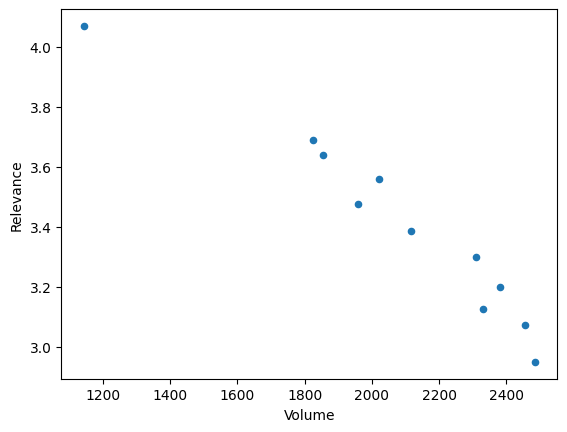

In [18]:
displayed_results.plot.scatter(x='Volume', y='Relevance')

## Step 7: Apply a PCA to visualize recommendations in 2D

In [19]:
%%time
from sklearn.manifold import TSNE

# Apply a tSNE on all semantic embeddings
movies_names_list = df_movies_plots['Title'].to_list()
mobies_plots_list = df_movies_plots['plot_semantic_embedding'].to_list()
X = np.array(mobies_plots_list)
#pca = PCA(n_components=2)
tsne = TSNE(n_components=2)
X_2d = tsne.fit_transform(X)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


CPU times: user 17.5 s, sys: 3.88 s, total: 21.4 s
Wall time: 2.87 s


In [20]:
def plot_two_sets_of_recos(results_top_k, results_k_diversified, results_k_diversified_no_qi, X_2d):
    plt.figure(figsize=(8, 6))

    # Plot top_k recommendations
    # TODO factor this
    top_k_movies_indices = [movies_names_list.index(movie_name.decode('utf-8')) for movie_name in results_top_k]
    print(top_k_movies_indices)
    plt.scatter([X_2d[i, 0] for i in top_k_movies_indices],
                [X_2d[i, 1] for i in top_k_movies_indices], 
                color='red', label="top $k$ recommendations", marker='.')
    for movie_id, name in zip(top_k_movies_indices, results_top_k):
        plt.annotate(name.decode('utf-8'), xy=X_2d[movie_id], xytext=X_2d[movie_id] + 0.02, c='red')

    # Plot diversified recommendations
    diversified_k_movies_indices = [movies_names_list.index(movie_name.decode('utf-8')) for movie_name in results_k_diversified]
    plt.scatter([X_2d[i, 0] for i in diversified_k_movies_indices],
                [X_2d[i, 1] for i in diversified_k_movies_indices], 
                color='blue', label="diversified $\lambda = 3$ recommendations", marker='.')

    # Plot diversified recommendations no q_i
    diversified_no_qi_k_movies_indices = [movies_names_list.index(movie_name.decode('utf-8')) for movie_name in results_k_diversified_no_qi]
    plt.scatter([X_2d[i, 0] for i in diversified_no_qi_k_movies_indices],
                [X_2d[i, 1] for i in diversified_no_qi_k_movies_indices], 
                color='forestgreen', label="diversified $\lambda = 0$ recommendations", marker='.')


    plt.title("Movie Embeddings ($t$-SNE 2D)")
    plt.xlabel("$t$-SNE axis 1")
    plt.ylabel("$t$-SNE axis 2")
    plt.legend()
    plt.grid(True)
    plt.show()


[606, 528, 914, 548, 514, 589, 628, 645, 631, 649]


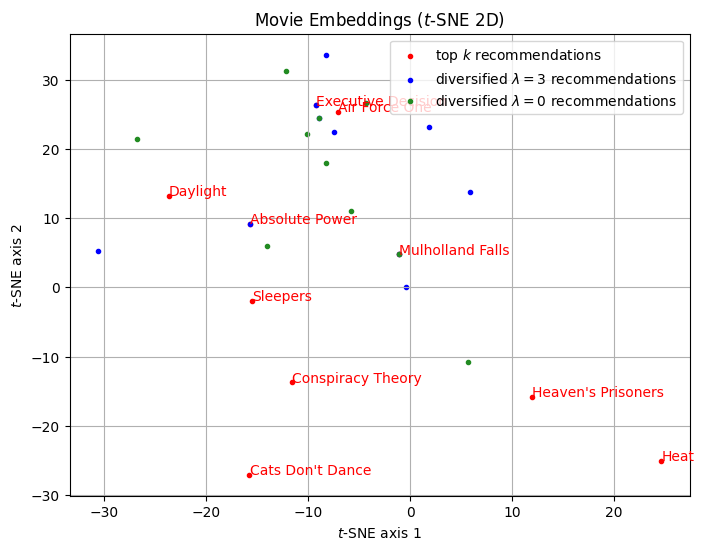

In [21]:
plot_two_sets_of_recos(results_top_k[0], results_k_diversified[0], results_k_diversified_no_qi[0], X_2d)

In [22]:
displayed_results['Volume ratio'] = displayed_results['Volume'] / volume_top_k

In [23]:
displayed_results

,Relevance,Volume,Volume ratio
Model A (top $K$),4.068948,1143.679688,1.000000
Model ($\lambda = 0.0$),2.949149,2484.105713,2.172029
Model ($\lambda = 0.3333333333333333$),3.073031,2454.123291,2.145813
Model ($\lambda = 0.6666666666666666$),3.125466,2331.796631,2.038855
Model ($\lambda = 1.0$),3.197375,2379.586914,2.080641
Model ($\lambda = 1.3333333333333333$),3.299338,2308.547119,2.018526
Model ($\lambda = 1.6666666666666665$),3.384029,2116.101807,1.850257
Model ($\lambda = 2.0$),3.476042,1958.441406,1.712404
Model ($\lambda = 2.333333333333333$),3.560382,2021.967285,1.767949
Model ($\lambda = 2.6666666666666665$),3.638576,1854.187500,1.621247


<Axes: xlabel='Volume ratio', ylabel='Relevance'>

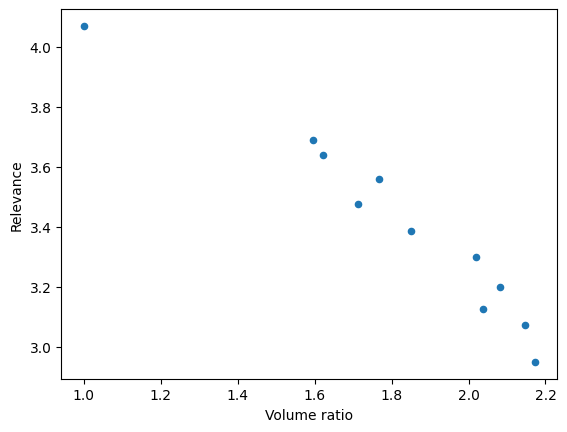

In [24]:
displayed_results.plot.scatter(x='Volume ratio', y='Relevance')

In [25]:
## Plot all movies in the movies dataset
#plot_two_sets_of_recos(df_movies_plots.Title.unique(),df_movies_plots.Title.unique(), X_2d)

# Remarks: 
- The two tower retrieval model is a dummy model. It does not necessarily perform well especially considering the 'factorized_top_k/top_*_categorical_accuracy'. This means that even the top-10 closest movies can be already diverse.
- With our data at pass culture, we observe a high impact of DPP sampling on diversity metrics. We typically have a factor of 12x or 15x gain in volume after samping with DPPs. Our business diversification metric also increased by at least 12%.
